# Split Learning with SplitGuard detection 

The method is proposed in paper <SplitGuard: Detecting and Mitigating Training-Hijacking Attacks in Split Learning>.

## Initialization and model defination

In [8]:
import os

import matplotlib.pyplot as plt

import secretflow as sf

sf.shutdown()
sf.init(["alice", "bob"], address="local", num_cpus=5)
alice, bob = sf.PYU("alice"), sf.PYU("bob")
parties = [alice, bob]
import torch
from torch import nn as nn
from torch.nn import functional as F

from secretflow.ml.nn.utils import BaseModule


# The model structure is different from the original paper, thus there is defference in the hyper-parameters and results.
class ConvNetBase(BaseModule):
    """Small ConvNet basenet for MNIST."""

    def __init__(self):
        super(ConvNetBase, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5,),
            nn.ReLU(False),
            nn.MaxPool2d(2, 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.ReLU(False),
            nn.MaxPool2d(2, 2),
        )
        self.out = nn.Linear(16 * 4 * 4, 120)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

    def output_num(self):
        return 1


class ConvNetFuse(BaseModule):
    """Small fusenet for MNIST."""

    def __init__(self):
        super(ConvNetFuse, self).__init__()
        self.fc1 = nn.Linear(120 * 2, 120)
        self.fc1act = nn.ReLU(False)
        self.fc2 = nn.Linear(120, 84)
        self.fc2act = nn.ReLU(False)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.cat(x, dim=1)
        x = x.view(-1, 240)
        x = self.fc1(x)
        x = self.fc1act(x)
        x = self.fc2(x)
        x = self.fc2act(x)
        x = self.fc3(x)
        return x

2023-10-21 12:37:07,118	INFO worker.py:1538 -- Started a local Ray instance.


## Use label replace to compute the SG score(replace 7 batches out of 79 batches) 

In [9]:
import math
import os
import random
import tempfile
from collections import namedtuple
from typing import Dict, List, Tuple, Union

import numpy as np
from torch import nn, optim
from torchmetrics import AUROC, Accuracy, Precision

from secretflow.data.ndarray import FedNdarray
from secretflow.device.device.pyu import PYU
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel
from secretflow.utils.simulation.data.ndarray import create_ndarray
from secretflow.utils.simulation.datasets import get_dataset
from slmodel_splitguard import SLModel_SG

_temp_dir = tempfile.mkdtemp()
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)

scores = []
_Dataset = namedtuple("_Dataset", ["filename", "url", "sha256"])
fake_batch = []
_DATASETS = {
    "mnist": _Dataset(
        "mnist.npz",
        "https://secretflow-data.oss-accelerate.aliyuncs.com/datasets/mnist/mnist.npz",
        "731c5ac602752760c8e48fbffcf8c3b850d9dc2a2aedcf2cc48468fc17b673d1",
    )
}


def load_mnist(
    parts_train: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    parts_test: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    normalized_x: bool = True,
    categorical_y: bool = False,
    is_torch: bool = False,
    batch_size: int = 32,
    N: int = 20,
    P_F: float = 0.1,
    B_F: int = 32,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    filepath = get_dataset(_DATASETS["mnist"])
    with np.load(filepath) as f:
        x_train, y_train = f["x_train"], f["y_train"]
        x_test, y_test = f["x_test"], f["y_test"]
    # Set fake batches as paper.
    batch_num = len(y_train) // batch_size
    for i in range(batch_num):
        send_fakes = i > N and random.random() <= P_F
        if send_fakes and B_F > 0:
            index = random.sample(range(batch_size), B_F)
            index = [item + batch_size * i for item in index]
            for idx in index:
                y_train[idx] = (y_train[idx] + random.randint(1, 8)) % 10
            fake_batch.append(i)
    if normalized_x:
        x_train, x_test = x_train / 255, x_test / 255

    if categorical_y:
        from sklearn.preprocessing import OneHotEncoder

        encoder = OneHotEncoder(sparse=False)
        y_train = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test = encoder.fit_transform(y_test.reshape(-1, 1))
    return (
        (
            create_ndarray(x_train, parts=parts_train, axis=0, is_torch=is_torch),
            create_ndarray(y_train, parts=parts_train, axis=0),
        ),
        (
            create_ndarray(x_test, parts=parts_test, axis=0, is_torch=is_torch),
            create_ndarray(y_test, parts=parts_test, axis=0),
        ),
    )


def create_dataset_builder(batch_size=32,):
    def dataset_builder(x):
        import pandas as pd
        import torch
        import torch.utils.data as torch_data

        x = [t.values if isinstance(t, pd.DataFrame) else t for t in x]
        x_copy = [torch.tensor(t.copy()) for t in x]

        data_set = torch_data.TensorDataset(*x_copy)
        dataloader = torch_data.DataLoader(dataset=data_set, batch_size=batch_size,)
        return dataloader

    return dataset_builder


def torch_model_with_mnist(
    devices,
    base_model_dict,
    device_y,
    model_fuse,
    data_train,
    label_train,
    data_test,
    label_test,
    batch_size,
    N,
    alpha,
    beta,
    strategy="split_nn",
    backend="torch",
    **kwargs
):
    # kwargs parsing
    dp_strategy_dict = kwargs.get("dp_strategy_dict", None)
    compressor = kwargs.get("compressor", None)
    dataset_builder = kwargs.get("dataset_builder", None)

    base_local_steps = kwargs.get("base_local_steps", 1)
    fuse_local_steps = kwargs.get("fuse_local_steps", 1)
    bound_param = kwargs.get("bound_param", 0.0)

    loss_thres = kwargs.get("loss_thres", 0.01)
    split_steps = kwargs.get("split_steps", 1)
    max_fuse_local_steps = kwargs.get("max_fuse_local_steps", 10)

    # Define model class using modified class SLModel_SG
    sl_model = SLModel_SG(
        base_model_dict=base_model_dict,
        device_y=device_y,
        model_fuse=model_fuse,
        dp_strategy_dict=dp_strategy_dict,
        compressor=compressor,
        simulation=True,
        random_seed=1234,
        backend=backend,
        strategy=strategy,
        N=N,
        alpha=alpha,
        beta=beta,
        fake_batch=fake_batch,
        base_local_steps=base_local_steps,
        fuse_local_steps=fuse_local_steps,
        bound_param=bound_param,
        loss_thres=loss_thres,
        split_steps=split_steps,
        max_fuse_local_steps=max_fuse_local_steps,
    )
    # The fit() function is modified.
    history = sl_model.fit(
        data_train,
        label_train,
        validation_data=(data_test, label_test),
        epochs=3,
        batch_size=batch_size,
        shuffle=False,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )
    global_metric = sl_model.evaluate(
        data_test,
        label_test,
        batch_size=batch_size,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )

    # test history
    print(global_metric)
    print(history)
    assert math.isclose(
        global_metric["MulticlassAccuracy"],
        history["val_MulticlassAccuracy"][-1],
        rel_tol=0.01,
    )

    base_model_path = os.path.join(_temp_dir, "base_model")
    fuse_model_path = os.path.join(_temp_dir, "fuse_model")
    sl_model.save_model(
        base_model_path=base_model_path, fuse_model_path=fuse_model_path, is_test=True,
    )
    return sl_model.results, history["val_MulticlassAccuracy"][-1]

In [10]:
def test_torch_model(devices, batch_size, N, P_F, B_F, alpha, beta):
    alice = devices[0]
    bob = devices[1]
    num_samples_train = 60000
    num_samples_test = 10000
    (
        (mnist_data_train, mnist_label_train),
        (mnist_data_test, mnist_label_test),
    ) = load_mnist(
        parts_train={alice: (0, num_samples_train), bob: (0, num_samples_train),},
        parts_test={alice: (0, num_samples_test), bob: (0, num_samples_test),},
        normalized_x=True,
        categorical_y=True,
        is_torch=True,
        batch_size=batch_size,
        N=N,
        P_F=P_F,
        B_F=B_F,
    )
    mnist_data_train = mnist_data_train.astype(np.float32)
    mnist_label_train = mnist_label_train.astype(np.float32)
    mnist_data_test = mnist_data_test.astype(np.float32)
    mnist_label_test = mnist_label_test.astype(np.float32)

    loss_fn = nn.CrossEntropyLoss
    optim_fn = optim_wrapper(optim.Adam, lr=1e-3)
    base_model = TorchModel(
        model_fn=ConvNetBase,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )

    fuse_model = TorchModel(
        model_fn=ConvNetFuse,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )
    base_model_dict = {
        alice: base_model,
        bob: base_model,
    }

    # test dataset builder
    print("test Dataset builder")
    dataset_builder_dict = {
        alice: create_dataset_builder(batch_size=batch_size,),
        bob: create_dataset_builder(batch_size=batch_size,),
    }
    result, acc = torch_model_with_mnist(
        devices=devices,
        base_model_dict=base_model_dict,
        device_y=bob,
        model_fuse=fuse_model,
        data_train=mnist_data_train,
        label_train=mnist_label_train,
        data_test=mnist_data_test,
        label_test=mnist_label_test,
        N=N,
        alpha=alpha,
        beta=beta,
        batch_size=batch_size,
        strategy="split_nn",
        backend="torch",
        dataset_builder=dataset_builder_dict,
    )
    return result, acc

test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd6c8abbe50>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd5c88ff0a0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fcee87946a0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fcee8572b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 3, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd54c0eb9d0>, PYURuntime(bob): <sec

{'val_loss': array(0.0904194, dtype=float32), 'MulticlassAccuracy': tensor(0.9247), 'MulticlassPrecision': tensor(0.9247), 'MulticlassAUROC': tensor(0.9944)}
{'train_loss': [array(0.24951267, dtype=float32), array(0.17442285, dtype=float32), array(0.15436612, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.7910), tensor(0.8340), tensor(0.8406)], 'train_MulticlassPrecision': [tensor(0.7910), tensor(0.8340), tensor(0.8406)], 'train_MulticlassAUROC': [tensor(0.9339), tensor(0.9416), tensor(0.9421)], 'val_val_loss': [array(0.2235732, dtype=float32), array(0.14372498, dtype=float32), array(0.0904194, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.9248), tensor(0.9316), tensor(0.9247)], 'val_MulticlassPrecision': [tensor(0.9248), tensor(0.9316), tensor(0.9247)], 'val_MulticlassAUROC': [tensor(0.9943), tensor(0.9953), tensor(0.9944)]}


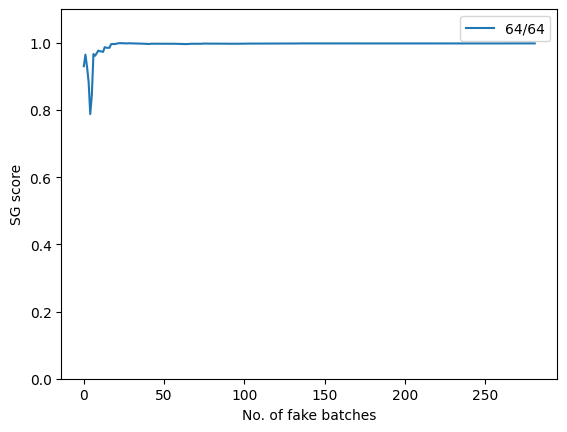

In [11]:
batch_size = 64
N = 20
P_F = 0.1
B_F = 64
alpha = 5
beta = 2
fake_batch = []
scores0, acc0 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)

plt.plot(scores0, label="64/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd4cee00700>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd54c0425e0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd4cee2f2b0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd4cee2f550>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 3, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd4cee2f460>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd4cee2f340>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(0.06604165, dtype=float32), 'MulticlassAccuracy': tensor(0.9472), 'MulticlassPrecision': tensor(0.9472), 'MulticlassAUROC': tensor(0.9972)}
{'train_loss': [array(0.11900919, dtype=float32), array(0.11806235, dtype=float32), array(0.15458412, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.8523), tensor(0.9010), tensor(0.9069)], 'train_MulticlassPrecision': [tensor(0.8523), tensor(0.9010), tensor(0.9069)], 'train_MulticlassAUROC': [tensor(0.9646), tensor(0.9706), tensor(0.9716)], 'val_val_loss': [array(0.0698258, dtype=float32), array(0.06269611, dtype=float32), array(0.06604165, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.9296), tensor(0.9448), tensor(0.9472)], 'val_MulticlassPrecision': [tensor(0.9296), tensor(0.9448), tensor(0.9472)], 'val_MulticlassAUROC': [tensor(0.9963), tensor(0.9976), tensor(0.9972)]}


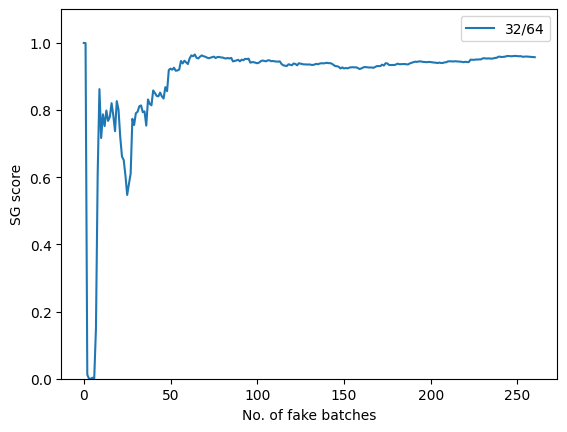

In [12]:
B_F = 32
fake_batch = []
scores1, acc1 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores1, label="32/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fcea06b1070>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fcea06b14c0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fcea06b1640>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fcea06b1520>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 3, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fcea06b1760>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fcea06b17c0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(0.04324595, dtype=float32), 'MulticlassAccuracy': tensor(0.9649), 'MulticlassPrecision': tensor(0.9649), 'MulticlassAUROC': tensor(0.9983)}
{'train_loss': [array(0.16153233, dtype=float32), array(0.1293231, dtype=float32), array(0.09504693, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.8798), tensor(0.9313), tensor(0.9377)], 'train_MulticlassPrecision': [tensor(0.8798), tensor(0.9313), tensor(0.9377)], 'train_MulticlassAUROC': [tensor(0.9792), tensor(0.9841), tensor(0.9845)], 'val_val_loss': [array(0.10577497, dtype=float32), array(0.05269019, dtype=float32), array(0.04324595, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.9447), tensor(0.9564), tensor(0.9649)], 'val_MulticlassPrecision': [tensor(0.9447), tensor(0.9564), tensor(0.9649)], 'val_MulticlassAUROC': [tensor(0.9976), tensor(0.9985), tensor(0.9983)]}


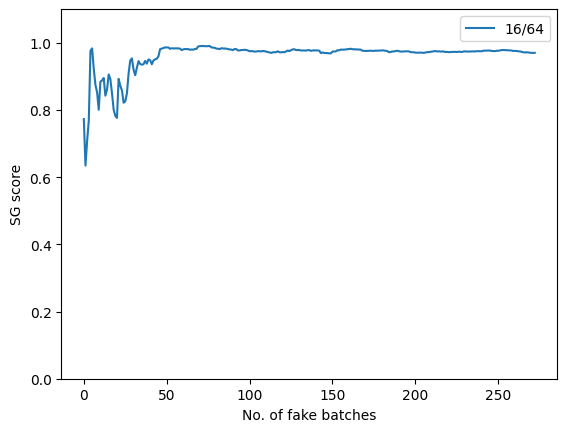

In [13]:
B_F = 16
fake_batch = []
scores2, acc2 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores2, label="16/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd5c88222b0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fcea0659d00>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd5c883e670>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fcea0659b50>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 3, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fcea04a1e50>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd5c883c430>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(0.00022617, dtype=float32), 'MulticlassAccuracy': tensor(0.9864), 'MulticlassPrecision': tensor(0.9864), 'MulticlassAUROC': tensor(0.9999)}
{'train_loss': [array(0.02471184, dtype=float32), array(0.00242214, dtype=float32), array(0.00255546, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.9183), tensor(0.9771), tensor(0.9838)], 'train_MulticlassPrecision': [tensor(0.9183), tensor(0.9771), tensor(0.9838)], 'train_MulticlassAUROC': [tensor(0.9954), tensor(0.9994), tensor(0.9997)], 'val_val_loss': [array(0.00288662, dtype=float32), array(0.00048218, dtype=float32), array(0.00022617, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.9712), tensor(0.9853), tensor(0.9864)], 'val_MulticlassPrecision': [tensor(0.9712), tensor(0.9853), tensor(0.9864)], 'val_MulticlassAUROC': [tensor(0.9994), tensor(0.9998), tensor(0.9999)]}


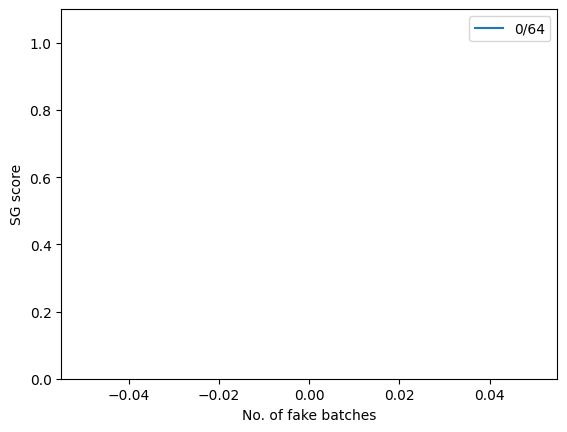

In [14]:
B_F = 0
fake_batch = []
scores3, acc3 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores3, label="0/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

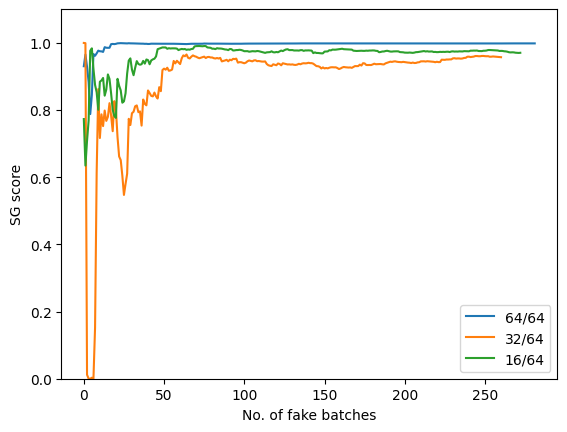

[]


In [17]:
plt.plot(scores0, label="64/64")
plt.plot(scores1, label="32/64")
plt.plot(scores2, label="16/64")

plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

In [16]:
print(
    "Test classification accuracy values for the MNIST dataset for different B_F values with SplitGuard, with P_F=0.1"
)
print("BF=64, ACC=", acc0)
print("BF=32, ACC=", acc1)
print("BF=16, ACC=", acc2)
print("BF=0, ACC=", acc3)

Test classification accuracy values for the MNIST dataset for different B_F values with SplitGuard, with P_F=0.1
BF=64, ACC= tensor(0.9247)
BF=32, ACC= tensor(0.9472)
BF=16, ACC= tensor(0.9649)
BF=0, ACC= tensor(0.9864)
